开始运行归一化间隙动力学分析 (N=1000000)...
生成真实素数数据...
生成静态混沌数据...
生成非自治(老化)混沌数据...


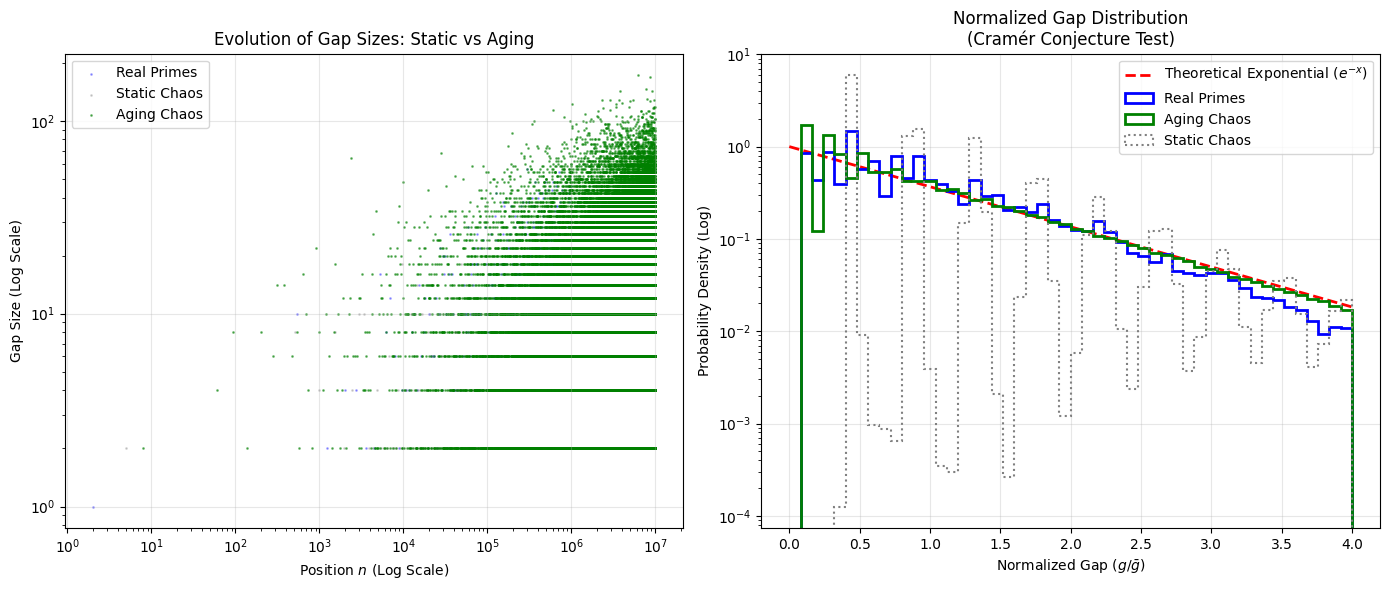

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon

def study_normalized_gap_dynamics(limit=1000000):
    print(f"开始运行归一化间隙动力学分析 (N={limit})...")
    
    # --- 1. 真实素数 (Real Primes) ---
    print("生成真实素数数据...")
    is_prime = np.ones(limit + 1, dtype=bool)
    is_prime[0:2] = False
    for i in range(2, int(limit**0.5) + 1):
        if is_prime[i]:
            is_prime[i*i : limit+1 : i] = False
    primes = np.nonzero(is_prime)[0]
    
    # 计算归一化间隙: g_n / ln(p_n)
    real_gaps = np.diff(primes)
    # 对应的局部平均间隙 ln(p_n)
    local_avg_real = np.log(primes[:-1])
    normalized_real = real_gaps / local_avg_real
    
    # --- 2. 静态混沌 (Static Chaos) ---
    print("生成静态混沌数据...")
    u = 1.543689012692076
    x = 0.1
    for _ in range(10000): x = 1 - u * x**2
    
    # 为了对比，生成相同数量级的点
    static_indices = []
    # 静态系统不需要跑太久就能拿到很多点
    for i in range(limit * 5): # 稍微跑多一点以确保样本够
        x = 1 - u * x**2
        if x < 0: # L区域
            static_indices.append(i)
            
    static_indices = np.array(static_indices)
    static_gaps = np.diff(static_indices)
    # 静态系统的平均间隙是常数，直接除以全局平均值
    normalized_static = static_gaps / np.mean(static_gaps)
    
    # --- 3. 非自治混沌 (Aging Chaos) ---
    print("生成非自治(老化)混沌数据...")
    # 机制: 产生 L 后，以 1/ln(n) 的概率保留
    # 这会使间隙随着 n 增大而变大
    
    aging_indices = []
    x = 0.1 # 重置 x
    # 预热
    for _ in range(10000): x = 1 - u * x**2
    
    # 注意：非自治系统效率较低，因为大部分点被过滤了
    # 我们模拟直到收集到足够样本，或者跑一定步数
    max_steps = limit * 10 
    
    # 这里的 scale k 不需要非常精确，因为我们最后会做归一化
    # 但为了效率，设一个合理的 k
    k = 4.5 
    
    for n in range(1, max_steps):
        if n < 3: continue
        x = 1 - u * x**2
        
        if x < 0: # 潜在的素数结构
            # 老化过滤: P = k / ln(n)
            # 我们用蒙特卡洛轮盘赌
            prob = k / np.log(n)
            if np.random.random() < prob:
                aging_indices.append(n)
    
    aging_indices = np.array(aging_indices)
    aging_gaps = np.diff(aging_indices)
    
    # 非自治系统的归一化: g_n / ln(n)
    # 注意这里分母是模拟的"时间" n，对应素数定理中的 ln(x)
    local_avg_aging = np.log(aging_indices[:-1])
    normalized_aging = aging_gaps / local_avg_aging  * k # 乘k是因为我们的密度差了个系数
    # 或者更简单的归一化方法：除以该序列的局部平滑均值 (Running Mean)
    # 为了严谨，我们用观测到的局部均值归一化
    
    def normalize_by_local_mean(series, window=1000):
        # 使用滑动窗口计算局部均值
        series_smooth = np.convolve(series, np.ones(window)/window, mode='same')
        return series / series_smooth

    # 重新归一化三者，确保公平对比“分布形状”
    norm_real_final = normalize_by_local_mean(real_gaps)
    norm_static_final = normalize_by_local_mean(static_gaps)
    norm_aging_final = normalize_by_local_mean(aging_gaps)

    # --- 4. 绘图 ---
    plt.figure(figsize=(14, 6), dpi=100)
    
    # 子图1: 间隙增长趋势 (Gap Evolution)
    plt.subplot(1, 2, 1)
    # 降采样绘制散点，避免卡顿
    plt.scatter(primes[:-1][::100], real_gaps[::100], s=1, alpha=0.3, label='Real Primes', color='blue')
    
    # 静态混沌看起来应该是一条水平带
    plt.scatter(static_indices[:-1][::100], static_gaps[::100], s=1, alpha=0.3, label='Static Chaos', color='gray')
    
    # 非自治混沌应该像素数一样发散
    plt.scatter(aging_indices[:-1][::10], aging_gaps[::10], s=1, alpha=0.5, label='Aging Chaos', color='green')
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Position $n$ (Log Scale)')
    plt.ylabel('Gap Size (Log Scale)')
    plt.title('Evolution of Gap Sizes: Static vs Aging')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 子图2: 归一化间隙分布 (Normalized Distribution)
    plt.subplot(1, 2, 2)
    
    # 理论指数分布
    x_axis = np.linspace(0, 4, 100)
    plt.plot(x_axis, np.exp(-x_axis), 'r--', lw=2, label='Theoretical Exponential ($e^{-x}$)')
    
    plt.hist(norm_real_final, bins=50, density=True, range=(0, 4), histtype='step', lw=2, label='Real Primes', color='blue')
    plt.hist(norm_aging_final, bins=50, density=True, range=(0, 4), histtype='step', lw=2, label='Aging Chaos', color='green')
    plt.hist(norm_static_final, bins=50, density=True, range=(0, 4), histtype='step', lw=1.5, label='Static Chaos', color='gray', linestyle=':')
    
    plt.yscale('log')
    plt.title('Normalized Gap Distribution\n(Cramér Conjecture Test)')
    plt.xlabel('Normalized Gap ($g / \\bar{g}$)')
    plt.ylabel('Probability Density (Log)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

study_normalized_gap_dynamics()